# Use image generator to feed tfrecord
[tensorflow Images](https://tensorflow.org/api_guides/python/image) <br>
```python
im_gen_obj = PatchImageGenerator()
patch_image = im_gen_obj.next_patch()
```
****
### Fix and test:
* digipath_mltk.py & or digipath_toolkit.py
    * err-parameters checking

In [8]:
import time
nb_start_time = time.time()

import os
import tempfile
import sys

from collections import OrderedDict
import argparse

import tensorflow as tf
from tensorflow import io as tf_io

import numpy as np
import pandas as pd
import yaml

from skimage.filters import threshold_otsu
from skimage.color import rgb2lab

from PIL import ImageDraw
from PIL import TiffImagePlugin as tip

import IPython.display as ip_display

import openslide

sys.path.insert(0, '../src/python')
from digipath_toolkit import *

In [2]:
"""
            copy - import from src/python/openslide_2_tfrecord.py
"""

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# def image_patch(image_string, label, ulc_row, ulc_col, lrc_row, lrc_col, image_name='patch'):
#     """ image_metadat_dict = image_example(image_string, label, image_name)
#     Create a dictionary of jpg image features
#     Args:
#         image_string:  bytes(PIL_image)
#         label:         a number
#         image_name:    bytes(image_name)
#     Returns:
#         one_tf_train_example: tf.train.Example 
#     """
#     image_shape = tf.image.decode_jpeg(image_string).shape
#     feature = {'height': _int64_feature(image_shape[0]),
#                'width': _int64_feature(image_shape[1]),
#                'depth': _int64_feature(image_shape[2]),
#                'ulc_row': _int64_feature(ulc_row),
#                'ulc_col': _int64_feature(ulc_col),
#                'lrc_row': _int64_feature(lrc_row),
#                'lrc_col': _int64_feature(lrc_col),
#                'label': _int64_feature(label), 
#                'image_name': _bytes_feature(image_name),
#                'image_raw': _bytes_feature(image_string) }

#     return tf.train.Example(features=tf.train.Features(feature=feature))

def tf_imp_dict(image_string, label, image_name='patch'):
    image_shape = tf.image.decode_jpeg(image_string).shape
    feature = {'height': _int64_feature(image_shape[0]),
               'width': _int64_feature(image_shape[1]),
               'depth': _int64_feature(image_shape[2]),
               'label': _int64_feature(label), 
               'image_name': _bytes_feature(image_name),
               'image_raw': _bytes_feature(image_string) }

    return tf.train.Example(features=tf.train.Features(feature=feature))

def _parse_tf_imp_dict(example_proto):
    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string) }

    return tf.io.parse_single_example(example_proto, image_feature_description)


# def _parse_image_patch_function(example_proto):
#     """ reader for image_example() encoded as tfrecord file 
#         usage:
#     parsed_image_dataset = tf.data.TFRecordDataset(tfrecord_name).map(_parse_image_function)
    
#     Args: 
#         example_proto:
        
#     Returns:
#         iterable_tfrecord:   try iterable_tfrecord.__iter__()
#     """
#     image_feature_description = {
#         'height': tf.io.FixedLenFeature([], tf.int64),
#         'width': tf.io.FixedLenFeature([], tf.int64),
#         'depth': tf.io.FixedLenFeature([], tf.int64),
#         'ulc_row': tf.io.FixedLenFeature([], tf.int64),
#         'ulc_col': tf.io.FixedLenFeature([], tf.int64),
#         'lrc_row': tf.io.FixedLenFeature([], tf.int64),
#         'lrc_col': tf.io.FixedLenFeature([], tf.int64),
#         'label': tf.io.FixedLenFeature([], tf.int64),
#         'image_name': tf.io.FixedLenFeature([], tf.string),
#         'image_raw': tf.io.FixedLenFeature([], tf.string) }

#     return tf.io.parse_single_example(example_proto, image_feature_description)


def get_iterable_tfrecord(tfr_name):
    """ usage:
    iterable_tfrecord = get_iterable_tfrecord(tfr_name)
    
    Args:
        tfr_name:   tensorflow data TFRecord file
        
    Returns:
        TFRecordDataset_map_object:  tf.data.TFRecordDataset().map()
        _parse_tf_imp_dict
    """
    #     return tf.data.TFRecordDataset(tfr_name).map(_parse_image_patch_function)
    return tf.data.TFRecordDataset(tfr_name).map(_parse_tf_imp_dict)


In [3]:
COMMON_THUMBNAIL_DIVISOR = 20

data_dir = '../../DigiPath_MLTK_data/Aperio'
file_type_list=['.svs', '.tif', '.tiff']
fs_od = get_file_size_ordered_dict(data_dir, file_type_list)
list_number = 0
for k, v in fs_od.items():
    print('%3i %30s: %i'%(list_number, k,v))
    list_number += 1

  0         CMU-1-Small-Region.svs: 1938955
  1               JP2K-33003-1.svs: 63847265
  2           CMU-1-JP2K-33005.svs: 132565343
  3                      CMU-1.svs: 177552579
  4                      CMU-3.svs: 253815723
  5               JP2K-33003-2.svs: 289250433
  6                      CMU-2.svs: 390750635


In [5]:
data_dir = '../../DigiPath_MLTK_data/Aperio'
image_file_name = 'CMU-1.svs'

run_parameters = dict()

run_parameters['wsi_filename'] = os.path.join(data_dir, image_file_name)
print('Image File:\n', run_parameters['wsi_filename'])

run_parameters['thumbnail_divisor'] = COMMON_THUMBNAIL_DIVISOR
run_parameters['patch_select_method'] = 'threshold_otsu' # 'threshold_rgb2lab'
run_parameters['patch_height'] = 224
run_parameters['patch_width'] = 224
run_parameters['threshold'] = 0
run_parameters['image_level'] = 2

run_parameters['class_label'] = 'class_label_test_str'
run_parameters['output_dir'] = '../../run_dir/tfrecord_result'
            
# patch_generator = PatchImageGenerator(run_parameters)
for k, v in run_parameters.items():
    print('%25s: %s'%(k,v))

Image File:
 ../../DigiPath_MLTK_data/Aperio/CMU-1.svs
             wsi_filename: ../../DigiPath_MLTK_data/Aperio/CMU-1.svs
        thumbnail_divisor: 20
      patch_select_method: threshold_otsu
             patch_height: 224
              patch_width: 224
                threshold: 0
              image_level: 2
              class_label: class_label_test_str
               output_dir: ../../run_dir/tfrecord_result


In [6]:
"""
                optimistic first try
"""
_, file_name_base = os.path.split(run_parameters['wsi_filename'])
file_name_base, _ = os.path.splitext(file_name_base)

h = run_parameters['patch_height']
w = run_parameters['patch_width']
class_label = run_parameters['class_label']
output_dir = run_parameters['output_dir']

file_ext = ''

if os.path.isdir(output_dir) == False:
    os.makedirs(output_dir)
    print('created new dir:',output_dir)

tfrecord_file_name = file_name_base + '.tfrecords'
tfrecord_file_name = os.path.join(output_dir, tfrecord_file_name)

patch_image_name_dict = {'case_id': file_name_base, 'class_label': class_label, 'file_ext': file_ext}

patch_generator = PatchImageGenerator(run_parameters)
with tf_io.TFRecordWriter(tfrecord_file_name) as writer:
    seq_number = 0
    while True:
        try:
            patch_dict = patch_generator.next_patch()
            x = patch_dict['image_level_x']
            y = patch_dict['image_level_y']
            patch_image_name_dict['location_x'] = x
            patch_image_name_dict['location_y'] = y
            patch_name = dict_to_patch_name(patch_image_name_dict)
            
            image_string = patch_dict['patch_image'].convert('RGB')
            
            tmp = tempfile.NamedTemporaryFile(delete=False, suffix='.jpg')
            try:
                image_string.save(tmp.name)
                image_string = open(tmp.name, 'rb').read()
            finally:
                os.unlink(tmp.name)
                tmp.close()

            tf_example_obj = tf_imp_dict(image_string,
                                         label=seq_number,
                                         image_name=bytes(patch_name,'utf8') )

            writer.write(tf_example_obj.SerializeToString())
            seq_number += 1
        except StopIteration:
            print('Iteration Stopped by Image Generator Signal: StopIteration')
            break

print(seq_number)

Iteration Stopped by Image Generator Signal: StopIteration
46


tf.Tensor(0, shape=(), dtype=int64) tf.Tensor(b'CMU-1_1662_21_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


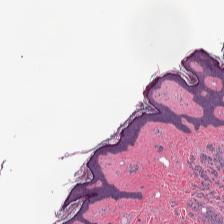

tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(b'CMU-1_1886_21_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


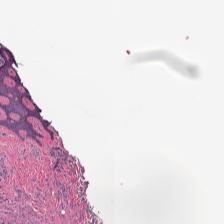

tf.Tensor(2, shape=(), dtype=int64) tf.Tensor(b'CMU-1_2110_21_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


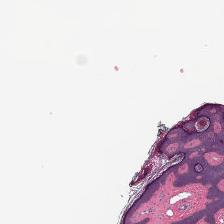

tf.Tensor(3, shape=(), dtype=int64) tf.Tensor(b'CMU-1_2334_21_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


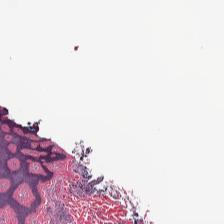

tf.Tensor(4, shape=(), dtype=int64) tf.Tensor(b'CMU-1_1662_245_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


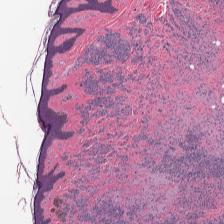

tf.Tensor(5, shape=(), dtype=int64) tf.Tensor(b'CMU-1_1886_245_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


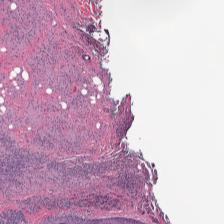

tf.Tensor(6, shape=(), dtype=int64) tf.Tensor(b'CMU-1_2110_245_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


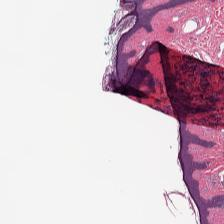

tf.Tensor(7, shape=(), dtype=int64) tf.Tensor(b'CMU-1_2334_245_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


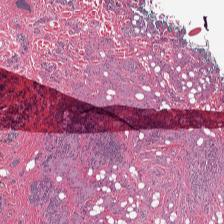

tf.Tensor(8, shape=(), dtype=int64) tf.Tensor(b'CMU-1_2558_245_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


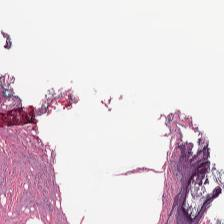

tf.Tensor(9, shape=(), dtype=int64) tf.Tensor(b'CMU-1_1662_469_class_label_test_str', shape=(), dtype=string)
<class 'bytes'>


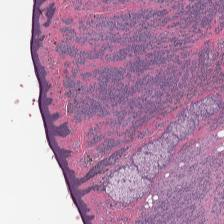

In [9]:
iterable_tfrecord = get_iterable_tfrecord(tfrecord_file_name)

n_to_show = 10
for dakine in iterable_tfrecord.take(n_to_show):
    print(dakine['label'], dakine['image_name'])
    image_raw = dakine['image_raw'].numpy()
    print(type(image_raw))
    ip_display.display(ip_display.Image(data=image_raw))

In [ ]:
nxt_dict = patch_generator.next_patch()
for k in nxt_dict.keys():
    print(k)
    
print('\n# %04i, %i row, %i col'%(nxt_dict['patch_number'], nxt_dict['image_level_y'], nxt_dict['image_level_x']))
display(nxt_dict['patch_image'])

In [ ]:
patch_generator = PatchImageGenerator(run_parameters)
print()
patch_count = 0
while True:
    try:
        #         print(G.next_patch())
        patch_dict = patch_generator.next_patch()
        x = patch_dict['image_level_x']
        y = patch_dict['image_level_y']
        print('%8i x,\t%8i y\tsize = '%(x, y), patch_dict['patch_image'].size)
        #         display the image:
        #display(patch_generator.next_patch()['patch_image'])
        patch_count += 1
        
    except StopIteration:
        print('StopIteration Exception thrown & caught')
        break
        
print('patch_number:', patch_dict['patch_number'], '\npatch_count:', patch_count)

In [ ]:
help(patch_generator)

In [ ]:
# import digipath_toolkit
# help(digipath_toolkit)

In [ ]:
lost_data_dir = '../../DigiPath_MLTK_data/lost_data/'
os.listdir(lost_data_dir)